In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc
import warnings
warnings.filterwarnings("ignore")

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


81

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 384
skip = 384

for person in range(1,33):
  print('Person No.' + str(person))

  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']

  # Assigning classes
  label[label<5] = 0
  label[label>=5] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(40):
    sig = eeg[i][:32, :]
    sig = baseline_remove(sig)
    # Segmenting into 3 seconds (384 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,32,window_size])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.1
Person No.2
Person No.3
Person No.4
Person No.5
Person No.6
Person No.7
Person No.8
Person No.9
Person No.10
Person No.11
Person No.12
Person No.13
Person No.14
Person No.15
Person No.16
Person No.17
Person No.18
Person No.19
Person No.20
Person No.21
Person No.22
Person No.23
Person No.24
Person No.25
Person No.26
Person No.27
Person No.28
Person No.29
Person No.30
Person No.31
Person No.32
(25600, 32, 384)
(25600,) (11120,) (14480,)
(25600,) (10520,) (15080,)


0

# **Proposed Architecture**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# **2D CNN NET**

In [ ]:
def simple_2D_CNN(x):
  '''x = Bidirectional(LSTM(64, return_sequences=True))(x)
  x = Dropout(0.1)(x)'''
  '''x = Bidirectional(LSTM(16, return_sequences=True))(x)'''
  #x = Reshape((x.shape[1], x.shape[2],1))(x)
  x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)

  x = Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)

  x = Conv2D(filters = 32, kernel_size = 7, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)

  x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)
  '''
  x1 = Flatten()(x[:,:,0,:])
  x2 = Flatten()(x[:,:,1,:])
  x2 = Concatenate()([x1, x2])

  for i in range(2, x.shape[2]):
    x1 = Flatten()(x[:,:,i,:])
    x2 = Concatenate()([x1, x2])

  x = Reshape((x.shape[3], x.shape[2]))(x2)
  #x = Reshape((x.shape[3], 256))(x2)
  x = Dropout(0.1)(x)

  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Dropout(0.1)(x)
  x = Bidirectional(LSTM(16, return_sequences=True))(x)
  x = Dropout(0.1)(x)'''

  x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)

  '''x = Conv2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)'''

  x = Dropout(0.1)(x)

  x = Flatten()(x)
  x = Dense(512, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(256, activation='elu')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model() :
  input_shape = (data.shape[1], data.shape[2], 1)
  a = Input(input_shape)
  out = simple_2D_CNN(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-04)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model

model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 384, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 384, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 192, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 192, 32)       12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 96, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 96, 32)         50208 

In [ ]:
def dilation_1DCNN_block(x, dilation_rate):
  initializer = tf.keras.initializers.LecunNormal()
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu',
             kernel_initializer=initializer)(x)
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu',
             kernel_initializer=initializer)(y)
  return y

def causal_dilation_1DCNN_block(x):
  initializer = tf.keras.initializers.LecunNormal()
  x = Conv1D(filters=8, kernel_size=11, strides=1, padding='causal', dilation_rate=1, activation='selu',
             kernel_initializer=initializer)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=8, kernel_size=11, strides=1, padding='causal', dilation_rate=1, activation='selu',
             kernel_initializer=initializer)(x)
  x = MaxPool1D(pool_size=2)(x)
  y1 = dilation_1DCNN_block(x, 1)
  x = MaxPool1D(pool_size=2)(x)
  y1 = MaxPool1D(pool_size=2)(y1)
  y2 = dilation_1DCNN_block(Add()([x, y1]), 2)
  y3 = dilation_1DCNN_block(Add()([y1, y2]), 4)
  y4 = dilation_1DCNN_block(Add()([y2, y3]), 8)
  x = Add()([y1, y2, y3, y4])
  x = MaxPool1D(pool_size=2)(x)
  x = Dropout(0.1)(x)
  x = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', dilation_rate=1, activation='selu',
             kernel_initializer=initializer)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=16, kernel_size=5, strides=1, padding='causal', dilation_rate=1, activation='tanh',
             kernel_initializer=initializer)(x)
  x = Dropout(0.1)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Flatten()(x)
  return x

def parallel_1D_CNN(x):
  x1 = causal_dilation_1DCNN_block(x[:,0,:,:])
  x2 = causal_dilation_1DCNN_block(x[:,1,:,:])
  x1 = Concatenate()([x1, x2])
  for i in range(2, x.shape[1]):
    x2 = causal_dilation_1DCNN_block(x[:,i,:,:])
    x1 = Concatenate()([x1, x2])
  x = Reshape((x.shape[1], x2.shape[1], 1))(x1)
  x = Conv2D(filters = 8, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)
  x = Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)
  x = Conv2D(filters = 32, kernel_size = 7, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)
  x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  x = MaxPool2D(pool_size=2)(x)

  x = Dropout(0.1)(x)

  x = Flatten()(x)
  x = Dense(256, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model() :
  input_shape = (data.shape[1], data.shape[2], 1)
  a = Input(input_shape)
  out = parallel_1D_CNN(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-04)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 256, 1)      0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 256, 1)      0           ['input_1[0][0]']                
 icingOpLambda)                                                                               

In [ ]:
def simple_2D_CNN(x):
  x = Bidirectional(LSTM(8, return_sequences=True))(x)
  x = Dropout(0.1)(x)
  x = Bidirectional(LSTM(4, return_sequences=True))(x)
  x = Dropout(0.1)(x)
  x = Bidirectional(LSTM(2, return_sequences=True))(x)
  x = Dropout(0.1)(x)
  #x = Bidirectional(LSTM(8, return_sequences=True))(x)
  #x = Dropout(0.1)(x)
  #x = Reshape((x.shape[1], x.shape[2],1))(x)

  x = Flatten()(x)
  x = Dense(512, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(256, activation='elu')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model() :
  input_shape = (data.shape[1], data.shape[2])
  a = Input(input_shape)
  out = simple_2D_CNN(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-06)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model

model = get_model()
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 256, 32)]         0         
                                                                 
 bidirectional_51 (Bidirecti  (None, 256, 16)          2624      
 onal)                                                           
                                                                 
 dropout_79 (Dropout)        (None, 256, 16)           0         
                                                                 
 bidirectional_52 (Bidirecti  (None, 256, 8)           672       
 onal)                                                           
                                                                 
 dropout_80 (Dropout)        (None, 256, 8)            0         
                                                                 
 bidirectional_53 (Bidirecti  (None, 256, 4)           176

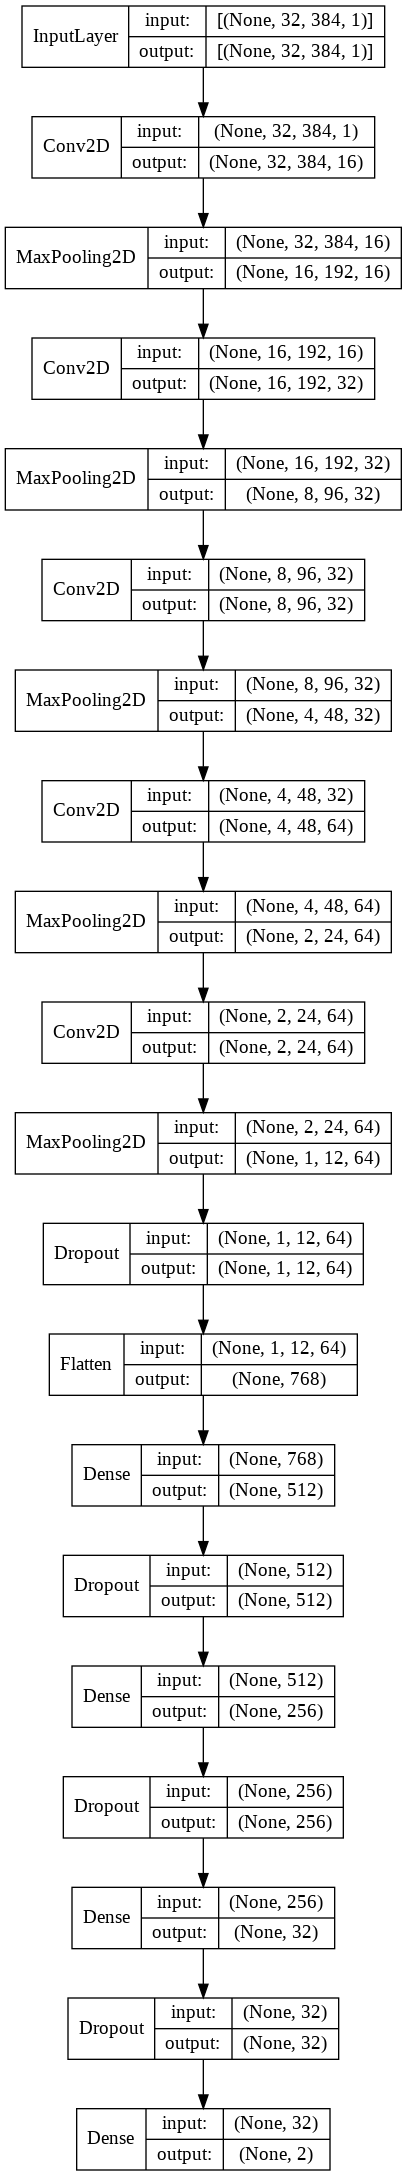

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
def get_CDB_model() :
  input_shape = (data.shape[1], data.shape[2],1)
  a = Input(input_shape)
  out = causal_dilation_1DCNN_block(a[:, 0, :, :])
  model = Model(a, out)
  return model

m = get_CDB_model()
m.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.__operators__.getitem_32 (S  (None, 256, 1)      0           ['input_2[0][0]']                
 licingOpLambda)                                                                                  
                                                                                                  
 conv1d_384 (Conv1D)            (None, 256, 8)       96          ['tf.__operators__.getitem_32[0][
                                                                 0]']                       

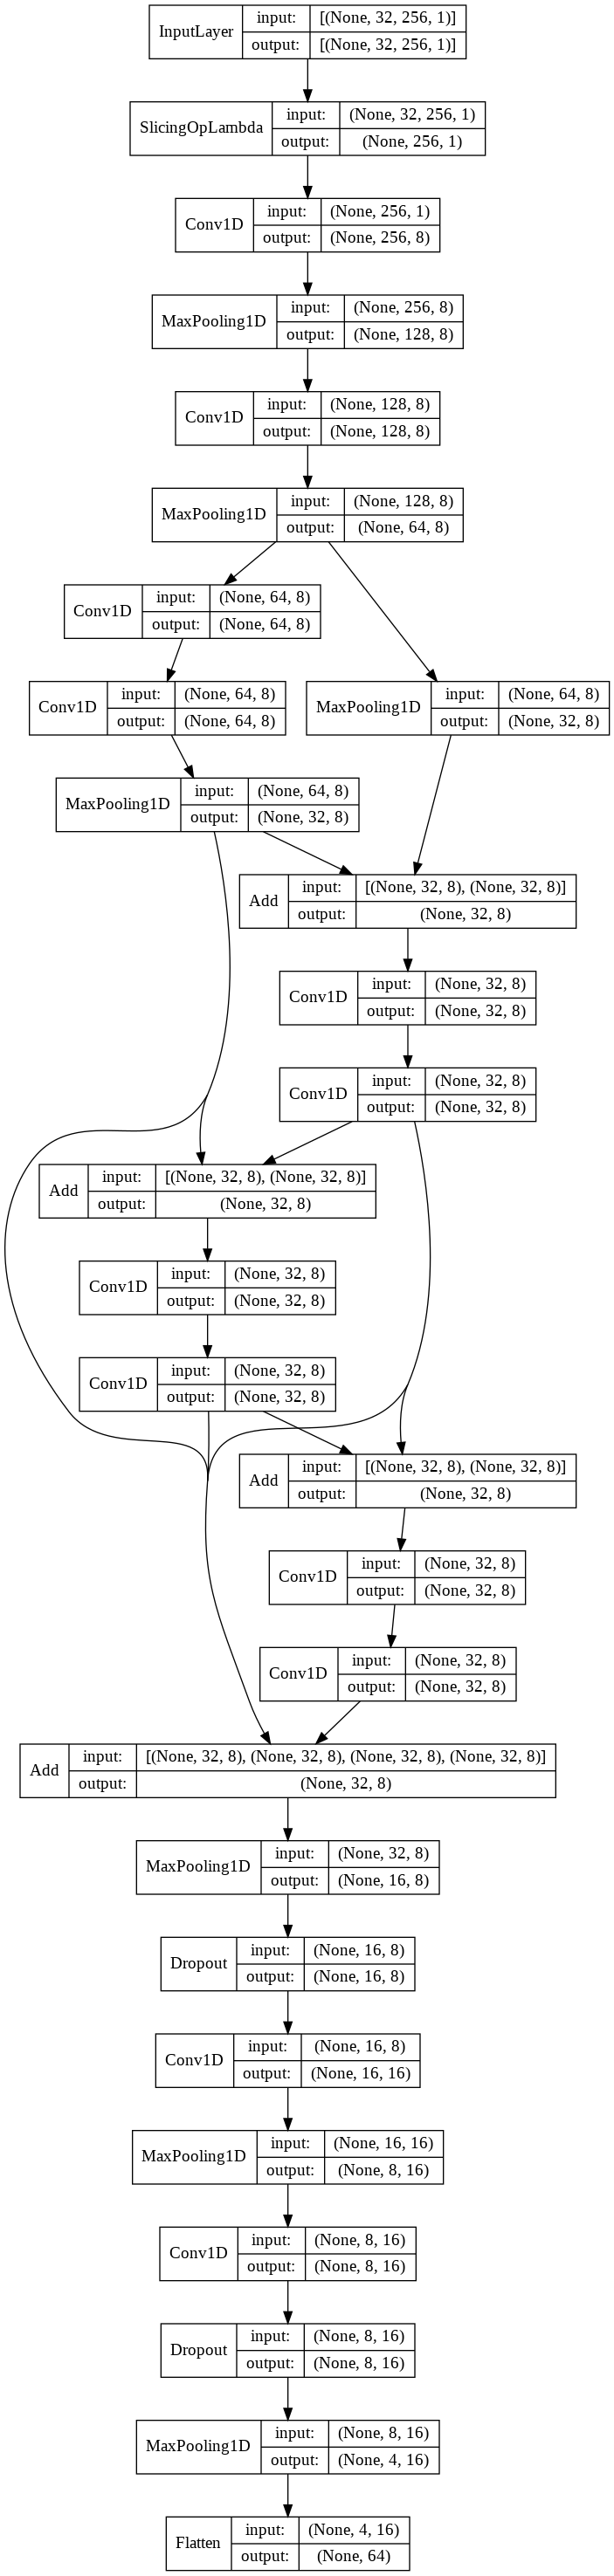

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(m, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
batch_size = 64
epochs = 30
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

874

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(23040, 32, 384) (2560, 32, 384) (23040, 2) (2560, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/30
324/324 [==============================] - 53s 162ms/step - loss: 0.7103 - accuracy: 0.5130 - val_loss: 0.6928 - val_accuracy: 0.5738
Epoch 2/30
191/324 [================>.............] - ETA: 21s - loss: 0.6936 - accuracy: 0.5360

KeyboardInterrupt: ignored

In [ ]:
acc = model.evaluate(x_test, y_test)
print(acc)
pred = model.predict(x_test)
f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
print(f1scr)
cnfsn = confusion_matrix(y_test.argmax(1), pred.argmax(1))
print(cnfsn)

40/40 [==============================] - 2s 33ms/step - loss: 0.7309 - accuracy: 0.8469
[0.7308708429336548, 0.846875011920929]
0.8429640534903693
[[441 110]
 [ 86 643]]


Accuracy  : 0.8581250131130218
F1_Score  : 0.8553197077529558


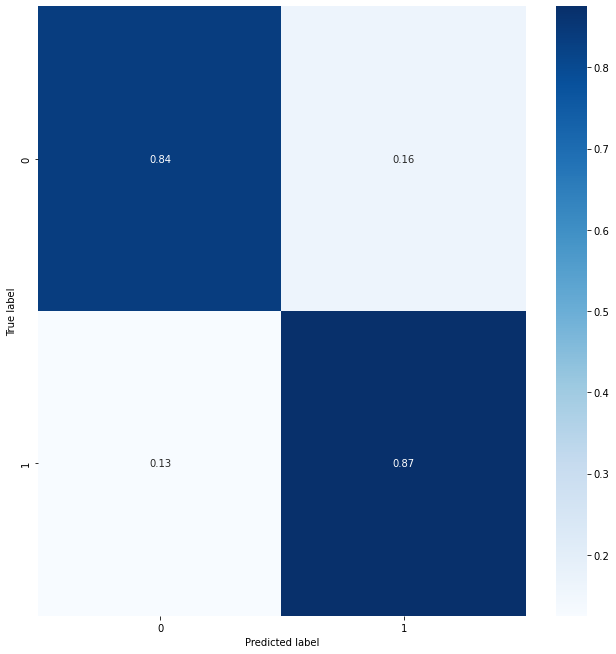

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(23040, 32, 384) (2560, 32, 384) (23040, 2) (2560, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/30
324/324 [==============================] - 52s 157ms/step - loss: 0.7018 - accuracy: 0.5188 - val_loss: 0.6928 - val_accuracy: 0.4735
Epoch 2/30
324/324 [==============================] - 51s 158ms/step - loss: 0.6934 - accuracy: 0.5128 - val_loss: 0.6929 - val_accuracy: 0.4818
Epoch 3/30
324/324 [==============================] - 51s 158ms/step - loss: 0.6926 - accuracy: 0.5281 - val_loss: 0.6872 - val_accuracy: 0.5734
Epoch 4/30
324/324 [==============================] - 51s 158ms/step - loss: 0.6878 - accuracy: 0.5386 - val_loss: 0.6797 - val_accuracy: 0.5703
Epoch 5/30
324/324 [==============================] - 51s 158ms/step - loss: 0.6651 - accuracy: 0.6053 - val_loss: 0.6633 - val_accuracy: 0.6076
Epoch 6/30
324/324 [==============================] - 51s 158ms/step - loss: 0.6471 - accuracy: 0.6303 - val_loss: 0.6254 - val_accuracy: 0.6519
Epoch 7/30
324/324 [==============================] - 51s 158ms/step - loss: 0.6263 - accuracy: 0.6512 - val_lo

Accuracy  : 0.8661718666553497
F1_Score  : 0.8624682911793837


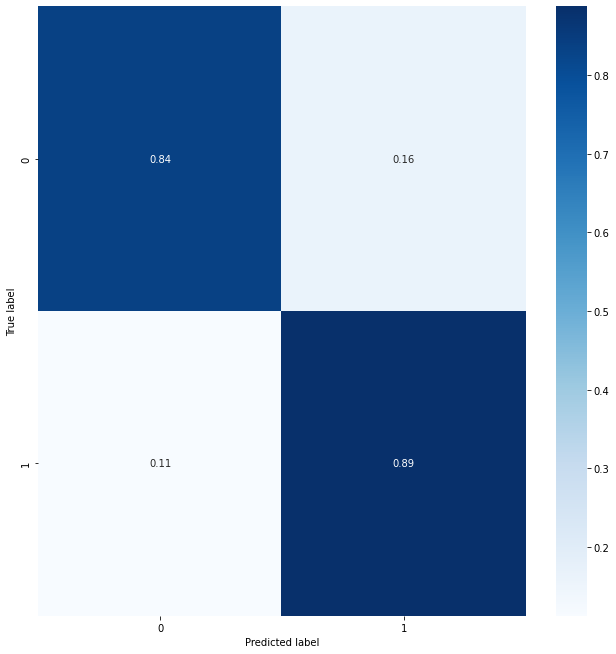

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
def LSTM_block(x):
  '''x = Bidirectional(LSTM(32, activation='selu', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None,
                           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True))(x)
  x = Bidirectional(LSTM(32, activation='selu', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None,
                           dropout=0.2, recurrent_dropout=0.2, return_state=True, go_backwards=True))(x)'''
  x = Bidirectional(LSTM(16, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                         recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                         bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None,
                         dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True, name='LSTM_1'))(x)
  x = Bidirectional(LSTM(16, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
                         recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                         bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None,
                         dropout=0.2, recurrent_dropout=0.2, go_backwards=True, name='LSTM_2'))(x)
  x = Reshape((x.shape[1], 1))(x)
  return x

def dilation_1DCNN_block(x, dilation_rate):
  initializer = tf.keras.initializers.LecunNormal()
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu',
             kernel_initializer=initializer)(x)
  y = Conv1D(filters=8, kernel_size=7, strides=1, padding='causal', dilation_rate=dilation_rate, activation='selu',
             kernel_initializer=initializer)(y)
  return y

def causal_dilation_1DCNN_block(x):
  initializer = tf.keras.initializers.LecunNormal()
  x = LSTM_block(x)
  x = Conv1D(filters=8, kernel_size=11, strides=1, padding='causal', dilation_rate=1, activation='selu',
             kernel_initializer=initializer)(x)
  y1 = dilation_1DCNN_block(x, 1)
  x = MaxPool1D(pool_size=2)(x)
  y1 = MaxPool1D(pool_size=2)(y1)
  y2 = dilation_1DCNN_block(Add()([x, y1]), 2)
  y3 = dilation_1DCNN_block(Add()([y1, y2]), 4)
  y4 = dilation_1DCNN_block(Add()([y2, y3]), 8)
  x = Add()([y1, y2, y3, y4])
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', dilation_rate=1, activation='selu',
             kernel_initializer=initializer)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', dilation_rate=1, activation='tanh',
             kernel_initializer=initializer)(x)
  x = Dropout(0.1)(x)
  x = MaxPool1D(pool_size=2)(x)
  x = Flatten()(x)
  return x

def channel_wise_attention(x):
  x1 = causal_dilation_1DCNN_block(x[:,0,:,:])
  x2 = causal_dilation_1DCNN_block(x[:,1,:,:])
  x1 = Concatenate()([x1, x2])
  for i in range(2, x.shape[1]):
    x2 = causal_dilation_1DCNN_block(x[:,i,:,:])
    x1 = Concatenate()([x1, x2])
  x = Reshape((x.shape[1], x2.shape[1], 1))(x1)
  y = AvgPool2D(pool_size=(1,x.shape[2]), name='AvgPool2D_1')(x)
  y = Flatten(name='Flatten_1')(y)
  y = Dense(5,activation='tanh', name='Dense_1') (y)
  y = Dense(32,activation='softmax', name='Dense_2') (y)
  x = Multiply(name='Multiply_1')([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])
  return x

def CNN_LSTM_Self_Attention(x):
  x = Conv2D(filters = 32, kernel_size = (32, 16), strides = (1, 1), padding = 'valid', name = 'Conv2D_1')(x)
  x = BatchNormalization(name='BatchNormalization_1')(x)
  x = Activation('elu', name = 'Activation_1')(x)
  x = MaxPool2D(pool_size=(1, x.shape[2]), name='MaxPool2D_1')(x)
  x = Reshape((1, x.shape[1]*x.shape[2]*x.shape[3]), name='Reshape_1')(x)
  '''x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None,
           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True, go_backwards=True, name='LSTM_1')(x)
  x = LSTM(32, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform',
           recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
           bias_regularizer=regularizers.l2(1e-4), activity_regularizer=regularizers.l2(1e-5), kernel_constraint=None,
           dropout=0.2, recurrent_dropout=0.2, return_sequences=True, go_backwards=True, name='LSTM_2')(x)'''
  y = MultiHeadAttention(num_heads=8, key_dim=8, name = 'MultiHeadAttention_1')(x, x)
  y = Activation('softmax', name = 'Activation_2')(y)
  x = Multiply(name='Multiply_2')([x, y])
  x = Flatten(name='Flatten_2')(x)
  #x = Dense(32, activation='relu', name='Dense_3') (x)
  x = Dense(2, activation='softmax', name='Dense_4') (x)
  return x
